In [62]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error

import src

%matplotlib inline

In [63]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config_paths()

In [64]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [65]:
exp = ['Test 5',
       'Test 7',
       'Test 8',
       'Test 9',
       'Test 11',
       'Test 14',
       'Test 15',
       'Test 16',
       'Test 17',
       'Test 18',
       'Test 19']

exp_data = {}
rms_data = {}

for e in exp:
    exp_data[e] = src.load(e)
    rms_data[e] = src.ae.ae.RMS(e)

--------------------------------------------------
Loaded RMS data for "22_08_03_grit1000"
Experiemnt No: Test 5
Number of files: 213
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_07_weartest_1000"
Experiemnt No: Test 7
Number of files: 163
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_09_weartest_1000"
Experiemnt No: Test 8
Number of files: 176
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "22_11_30_weartest_1000"
Experiemnt No: Test 9
Number of files: 158
--------------------------------------------------
--------------------------------------------------
Loaded RMS data for "24_05_28_weartest_D1.3#1000"
Experiemnt No: Test_99
Number of files: 139
--------------------------------------------------
-------------------------------------------------

In [66]:
runout = []
form_error = []
wear = []
probe = []

for e in exp:
    runout.append(exp_data[e].features['Runout'] * 1000)
    form_error.append(exp_data[e].features['Form error'] * 1000)
    mean_rad = exp_data[e].features['Mean radius']
    wear.append(np.abs(mean_rad - mean_rad.iloc[0]))
    if 'Probe diff' in exp_data[e].features:
        probe.append(_smooth(exp_data[e].features['Probe diff'], win=5))
    else:
        probe.append(np.NaN * np.ones_like(mean_rad))

## RAW AE

### FFT

In [67]:
def meanSquaredError(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred), axis=0)

def meanAbsoluteError(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=0)

In [68]:
FFT_RES = 1000
INPUT_I = 1
ERROR_FUNC = meanAbsoluteError

In [69]:
def raw_fft_scores(e_data, fft_res, input_i, error_func):

    # Check if exp has fft data
    if fft_res in e_data.ae.fft.keys():
        ffts = pd.DataFrame(e_data.ae.fft[1000])
    else:
        ffts = np.zeros((len(e_data.ae._files), int(1e6/fft_res)))
        for i in range(len(e_data.ae._files)):
            ffts[i, :] = e_data.ae._fftcalc(i, fft_res)
        ffts = e_data.ae.volt2db(np.array(ffts))
        ffts = pd.DataFrame(ffts)
    ffts.drop([0, 1, 2], axis=0, inplace=True)

    mean_fft = np.mean(ffts.values[:input_i, :], axis=0)
    mean_fft = np.tile(mean_fft, (ffts.shape[0], 1))
    mfft_scores = error_func(mean_fft.T, ffts.T)
    return mfft_scores

raw_fft_sc= []

for t, e in exp_data.items():
    raw_fft_sc.append(raw_fft_scores(e,
                                     FFT_RES,
                                     INPUT_I,
                                     ERROR_FUNC))

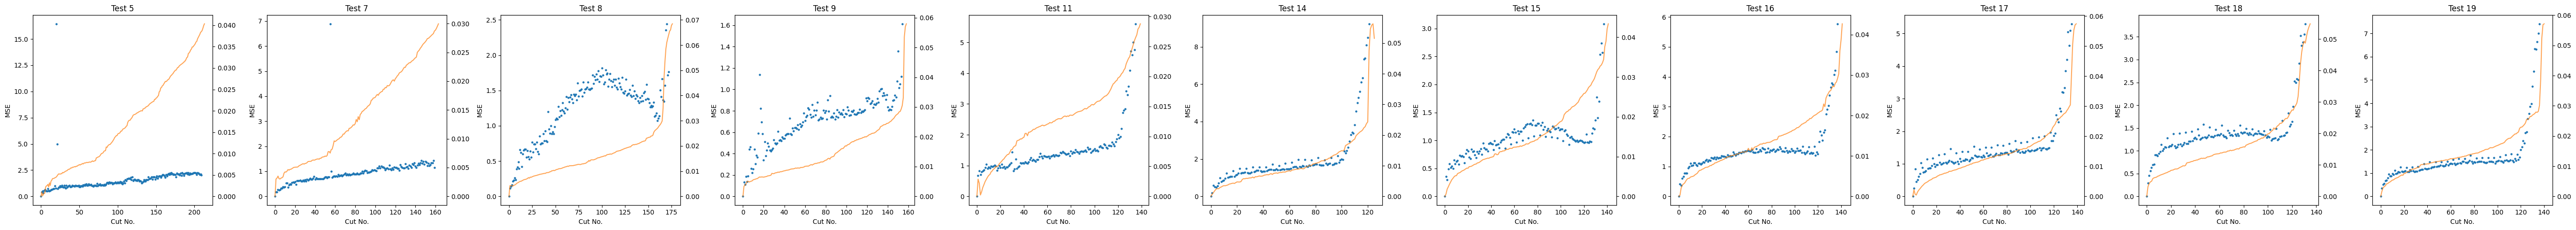

In [70]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(raw_fft_sc[i])), raw_fft_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(wear[i])), wear[i], 'C1', alpha=0.7, label='Wear')
fig.tight_layout()


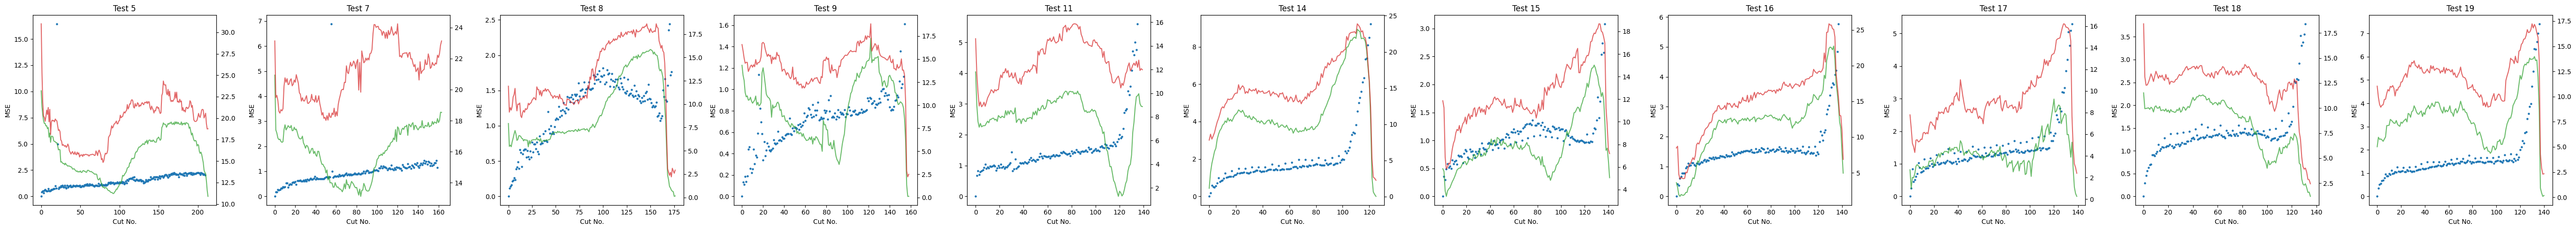

In [71]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(raw_fft_sc[i])), raw_fft_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(runout[i])), runout[i], 'C2', alpha=0.7, label='Runout')
    ax2[i].plot(range(len(form_error[i])), form_error[i], 'C3', alpha=0.7, label='Form error')
fig.tight_layout()

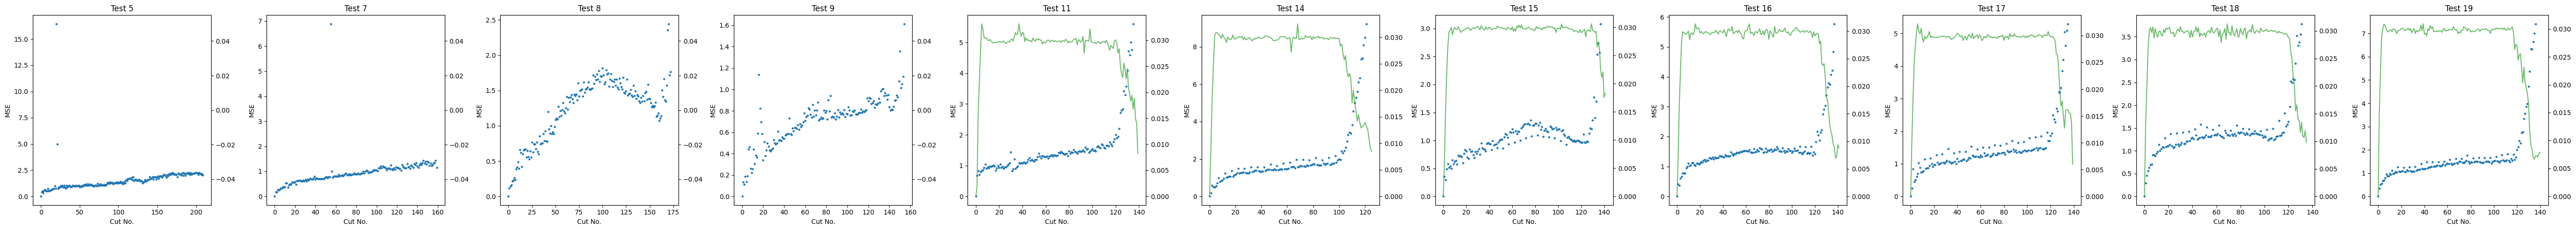

In [72]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(raw_fft_sc[i])), raw_fft_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(probe[i])), probe[i], 'C2', alpha=0.7, label='Probe DOC')
fig.tight_layout()

## RMS

### Time Domain

In [73]:
def remove_dc(sig):
    return sig - np.nanmean(sig)

In [74]:
def rms_time_scores(r_data, input_i, error_func=meanSquaredError):
    r = r_data.data.iloc[50:350, :].reset_index(drop=True)
    r = r.apply(remove_dc, axis=0)
    r = r.values.T

    mean_rms = np.mean(r[:input_i, :], axis=0)
    mean_rms = np.tile(mean_rms, (r.shape[0], 1))
    mrms_scores = error_func(mean_rms.T, r.T)
    return mrms_scores

rms_time_sc = []
for t, e in rms_data.items():
    rms_time_sc.append(rms_time_scores(rms_data[t],
                                       INPUT_I,
                                       ERROR_FUNC,
                                       ))

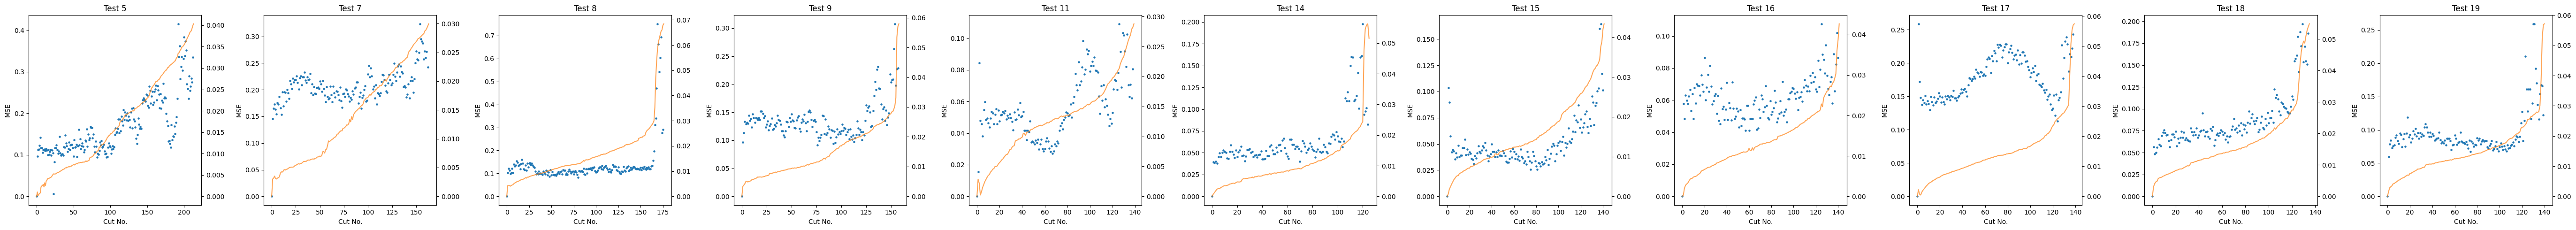

In [75]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(rms_time_sc[i])), rms_time_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(wear[i])), wear[i], 'C1', alpha=0.7, label='Wear')
fig.tight_layout()


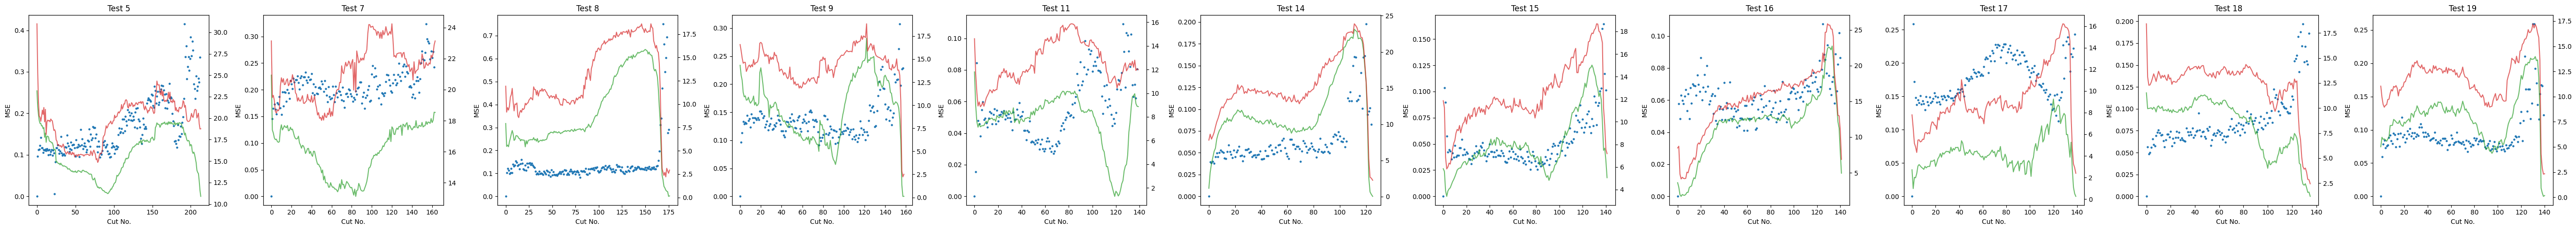

In [76]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(rms_time_sc[i])), rms_time_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(runout[i])), runout[i], 'C2', alpha=0.7, label='Runout')
    ax2[i].plot(range(len(form_error[i])), form_error[i], 'C3', alpha=0.7, label='Form error')
fig.tight_layout()

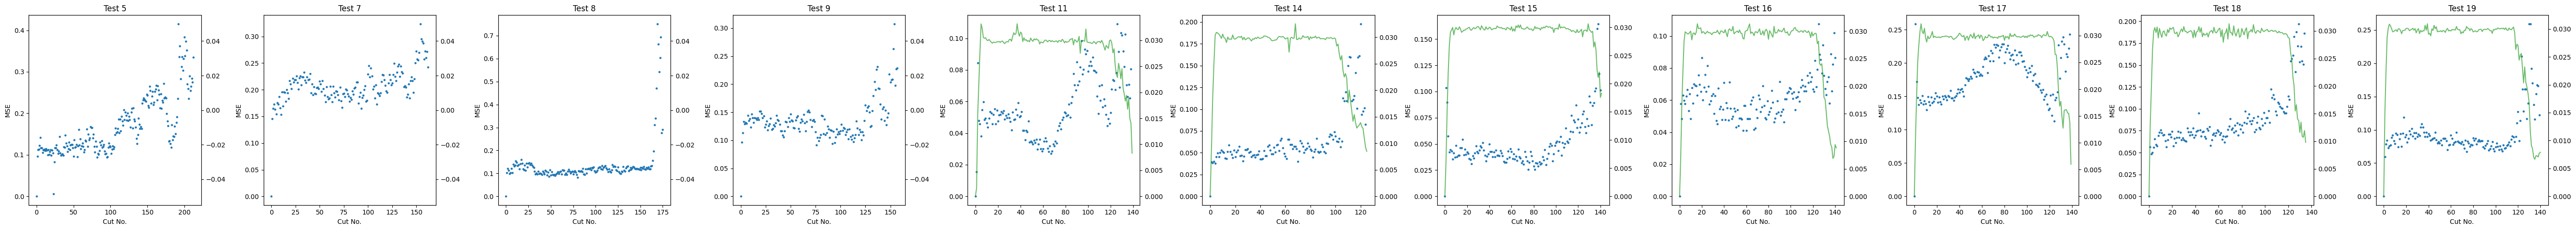

In [77]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(rms_time_sc[i])), rms_time_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(probe[i])), probe[i], 'C2', alpha=0.7, label='Probe DOC')
fig.tight_layout()

### Frequency Domain

In [78]:
def rms_freq_scores(r_data, input_i, error_func=meanSquaredError):
    r = r_data.data.iloc[50:350, :].reset_index(drop=True)
    r = r.apply(remove_dc, axis=0)
    r = r.values.T

    fft = np.fft.fft(r, axis=0)
    p2 = np.abs(fft/r.shape[0])
    p1 = p2[1:r.shape[0]//2+1, :]
    p1 = p1 * 2

    mean_rms_fft = np.mean(r[:input_i, :], axis=0)
    mean_rms_fft = np.tile(mean_rms_fft, (r.shape[0], 1))
    mrms_scores = error_func(mean_rms_fft.T, r.T)
    return mrms_scores

rms_freq_sc = []
for t, e in rms_data.items():
    rms_freq_sc.append(rms_freq_scores(rms_data[t],
                                       INPUT_I,
                                       error_func=ERROR_FUNC,
                                       ))

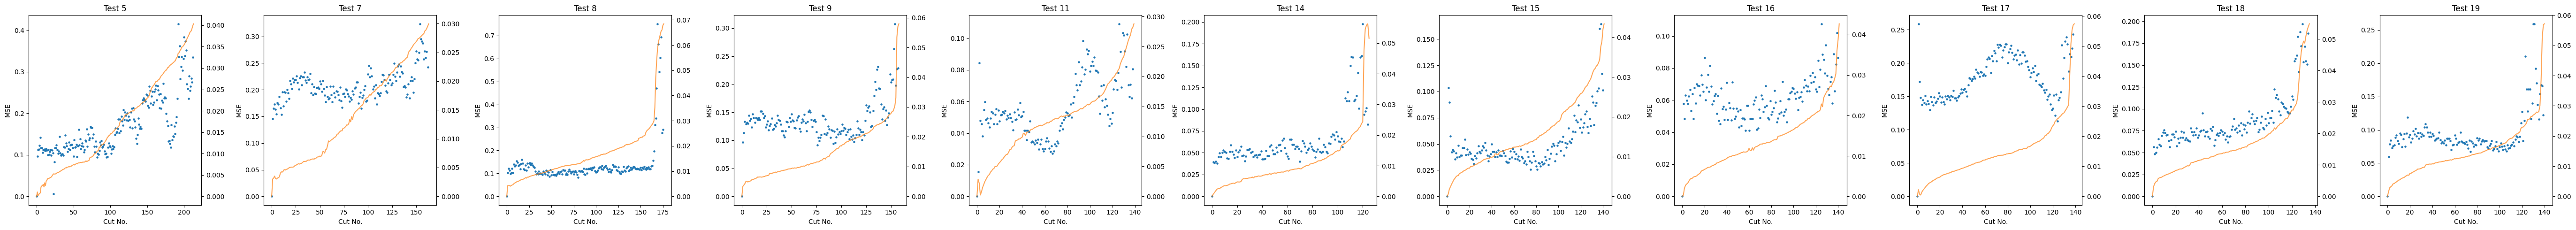

In [79]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(rms_freq_sc[i])), rms_freq_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(wear[i])), wear[i], 'C1', alpha=0.7, label='Wear')
fig.tight_layout()


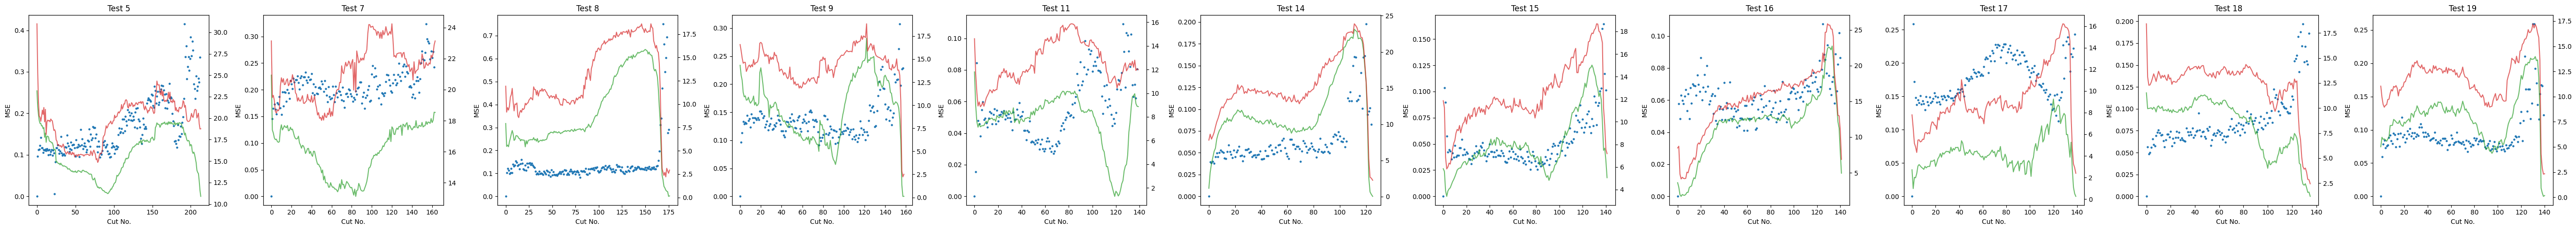

In [80]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(rms_freq_sc[i])), rms_freq_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(runout[i])), runout[i], 'C2', alpha=0.7, label='Runout')
    ax2[i].plot(range(len(form_error[i])), form_error[i], 'C3', alpha=0.7, label='Form error')
fig.tight_layout()

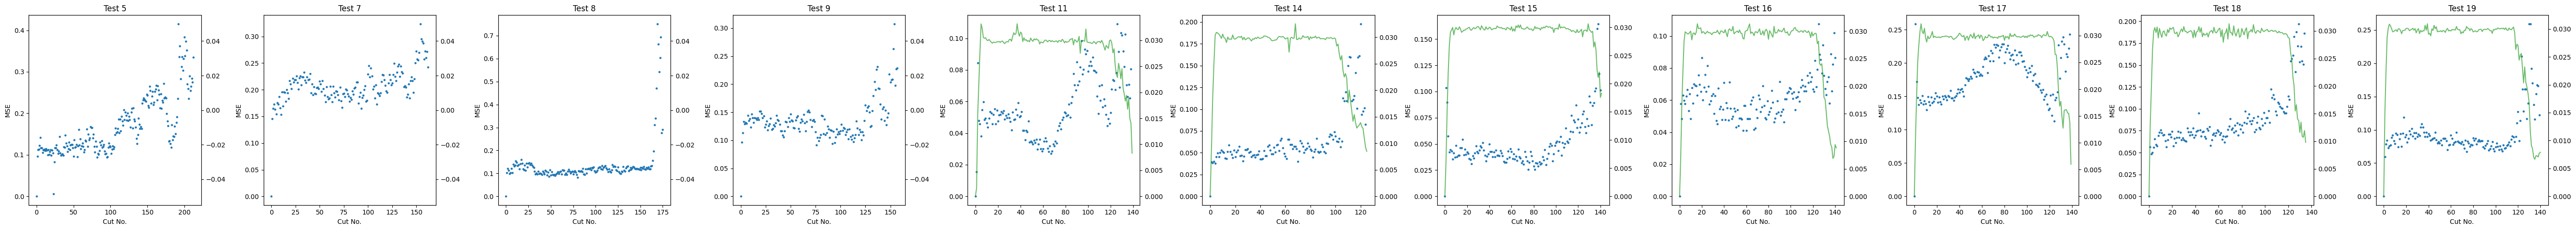

In [81]:
fig, ax = plt.subplots(1, len(exp), figsize=(len(exp) * 5, 5))
if len(exp) == 1:
    ax = [ax]
ax2 = []
for i, e in enumerate(exp):
    ax[i].scatter(range(len(rms_freq_sc[i])), rms_freq_sc[i], s=5, label='mse')
    ax[i].set_title(e)
    ax[i].set_xlabel('Cut No.')
    ax[i].set_ylabel('MSE')

    ax2.append(ax[i].twinx())
    ax2[i].plot(range(len(probe[i])), probe[i], 'C2', alpha=0.7, label='Probe DOC')
fig.tight_layout()